# Homework 4

## Import Libraries and data

In [243]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import torch.optim as optim
import tensorflow_hub as tfhub
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from scipy.spatial.distance import chebyshev
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(102)

In [244]:
df = pd.read_csv('../input/amazon-stock-price-all-time/Amazon.csv', parse_dates=True , index_col="Date")

## EDA
There is no null value so I don't need to do imputation. There is no duplicate value so I don't need to do data cleaning. The dates range from 1997-05-15 to 2021-10-27. Based on the visualization, the stock price before 2015 isn't changing much so I will only use dat from 2015 to 2021. I will choose 'Close' to predict.

In [245]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [246]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-21,3414.25000,3440.280029,3403.000000,3435.010010,3435.010010,1881400
2021-10-22,3421.00000,3429.840088,3331.300049,3335.550049,3335.550049,3133800
2021-10-25,3335.00000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
2021-10-26,3349.51001,3416.120117,3343.979980,3376.070068,3376.070068,2693700
2021-10-27,3388.00000,3412.000000,3371.453369,3396.189941,3396.189941,1080291


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6155 entries, 1997-05-15 to 2021-10-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6155 non-null   float64
 1   High       6155 non-null   float64
 2   Low        6155 non-null   float64
 3   Close      6155 non-null   float64
 4   Adj Close  6155 non-null   float64
 5   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 336.6 KB


In [248]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6155 entries, 1997-05-15 to 2021-10-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6155 non-null   float64
 1   High       6155 non-null   float64
 2   Low        6155 non-null   float64
 3   Close      6155 non-null   float64
 4   Adj Close  6155 non-null   float64
 5   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 336.6 KB


In [249]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [250]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,520.556302,526.216132,514.277282,520.429832,520.429832,7.329010e+06
std,857.161696,865.821041,847.270905,856.668492,856.668492,7.149521e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.750000,39.514999,38.104999,38.821251,38.821251,3.579350e+06
50%,92.669998,94.190002,90.750000,92.639999,92.639999,5.470000e+06
75%,528.949982,535.304993,521.950012,529.450012,529.450012,8.294950e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


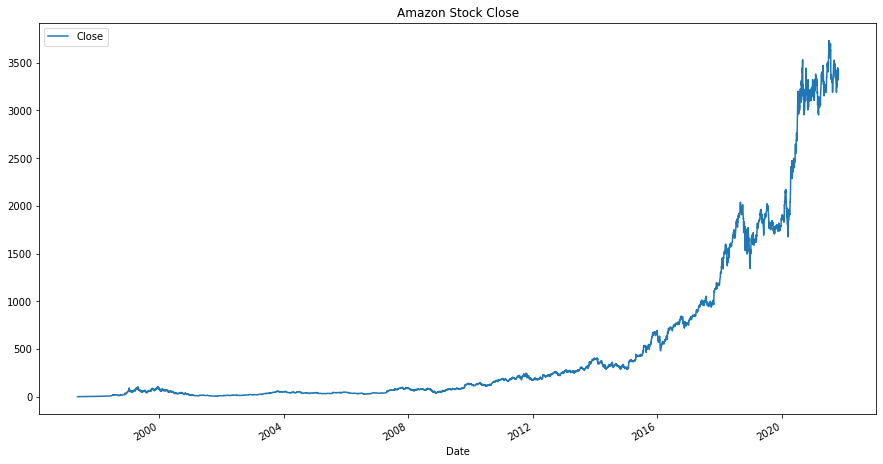

In [251]:
df[['Close']].plot(figsize = (15, 8))
plt.title('Amazon Stock Close')
plt.show()

### Stationary test
Perform KPSS stationary test. Although RNNs can predict non-stationary data, it is always good to check the stationary of a time series since a stationary data is easier for models to learn.

In [252]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [253]:
kpss_test(df['Close'])

KPSS Statistic: 8.061015470906401
p-value: 0.01
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



KPSS Statistic: 1.0435707471828748
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



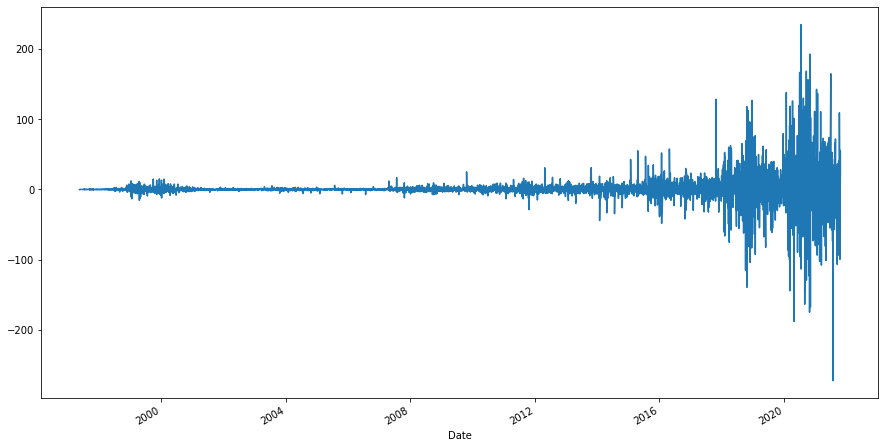

In [254]:
df['close_diff'] = df['Close'] - df['Close'].shift(1)
kpss_test(df['close_diff'].dropna())
plt.figure(figsize=(15, 8))
df['close_diff'].dropna().plot()
plt.show()

## Data Preprocessing

### Split dataset
I will use 2015 to 2018 as train data(1004, 2, 1), 2019 to 2020 as validation data(503, 2, 1), 2020 to 2021 as test data(205, 2, 1). The sequence length I choose is 2.

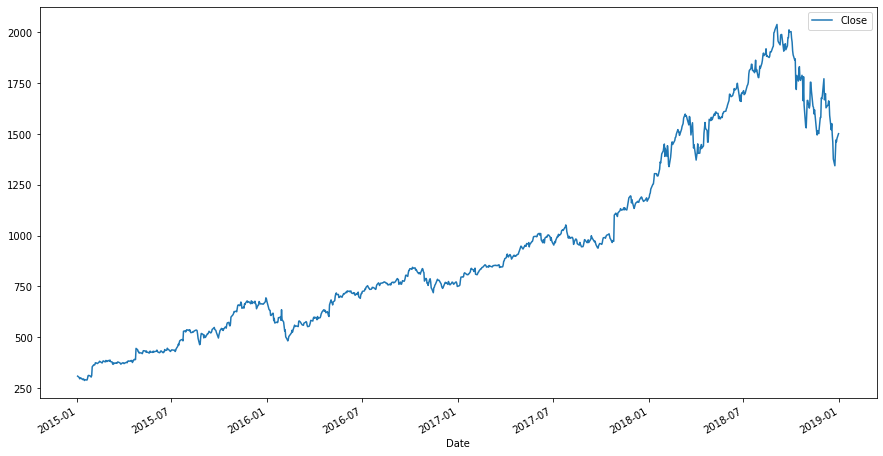

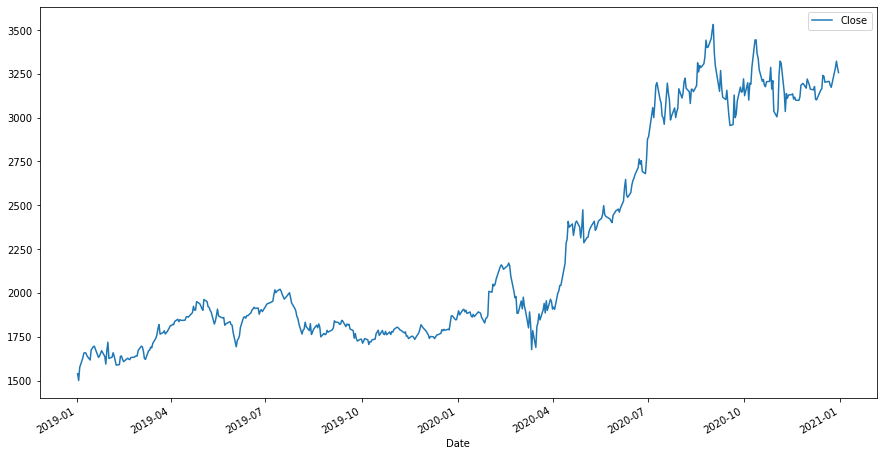

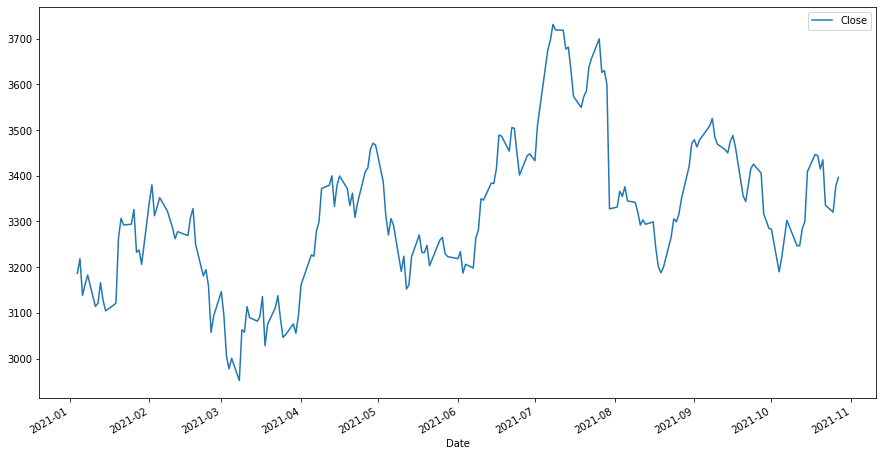

In [255]:
data = df[['Close']]['2015':]
train_data = data[:'2018']
val_data = data['2019':'2020']
test_data = data['2021':]
train_data.plot(figsize=(15, 8))
plt.show()
val_data.plot(figsize=(15, 8))
plt.show()
test_data.plot(figsize=(15, 8))
plt.show()

In [256]:
kpss_test(train_data['Close'])

KPSS Statistic: 4.609614635042011
p-value: 0.01
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [257]:
kpss_test(val_data['Close'])

KPSS Statistic: 3.0324485994855723
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [258]:
kpss_test(test_data['Close'])

KPSS Statistic: 0.8118484971041708
p-value: 0.01
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [259]:
def split_series(series, seq_length):
    X = []
    Y = []
    for i in range(seq_length, len(series.values)):
        X.append(series.values[i - seq_length: i])
        Y.append(series.values[i])
    
    return np.array(X), np.array(Y)

In [260]:
seq_length = 2
X_train, Y_train = split_series(train_data, seq_length=seq_length)
X_val, Y_val = split_series(val_data, seq_length=seq_length)
X_test, Y_test = split_series(test_data, seq_length=seq_length)
X_train.shape, X_val.shape, X_test.shape

((1004, 2, 1), (503, 2, 1), (205, 2, 1))

## Models
The activation function I used for all three model is 'ReLU'. All three models have 3 layers, a RNN/LSTM/GRU layer(all have 50 hidden states) and two dense layer(the last layer output a predict value). I used Mean Squared Error for calculating loss

### Hyperparameters

In [261]:
N_EPOCHS = 20
BATCH_SIZE = 16

### RNN

In [262]:
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(50, activation='relu'))
rnn_model.add(layers.Dense(25))
rnn_model.add(layers.Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
rnn_results = rnn_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
rnn_history = pd.DataFrame(rnn_results.history)

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 93469.9688 - mean_absolute_error: 169.9915 - val_loss: 3205.3586 - val_mean_absolute_error: 39.1806
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 676.7887 - mean_absolute_error: 15.9830 - val_loss: 3216.0691 - val_mean_absolute_error: 39.2701
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 645.8764 - mean_absolute_error: 15.6751 - val_loss: 3178.1343 - val_mean_absolute_error: 39.0058
Epoch 4/20
63/63 [==============================] - 0s 3ms/step - loss: 676.0464 - mean_absolute_error: 16.2381 - val_loss: 3607.9597 - val_mean_absolute_error: 42.6926
Epoch 5/20
63/63 [==============================] - 0s 3ms/step - loss: 656.5319 - mean_absolute_error: 16.0694 - val_loss: 3256.3640 - val_mean_absolute_error: 39.7025
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 639.0120 - mean_absolute_error: 15.5367 - val_loss: 3171.0217 - val_mean_absolut

In [263]:
rnn_val_preds = rnn_model.predict(X_val)
rnn_test_preds = rnn_model.predict(X_test)
rnn_test_mae = MeanAbsoluteError()(Y_test, rnn_test_preds)
rnn_val_preds.shape, rnn_test_preds.shape

((503, 1), (205, 1))

### LSTM

In [264]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(50, activation='relu'))
lstm_model.add(layers.Dense(25))
lstm_model.add(layers.Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
lstm_results = lstm_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
lstm_history = pd.DataFrame(lstm_results.history)

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 469776.0938 - mean_absolute_error: 527.3446 - val_loss: 10676.6758 - val_mean_absolute_error: 89.9196
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 908.9464 - mean_absolute_error: 19.7375 - val_loss: 2706.0991 - val_mean_absolute_error: 36.0628
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 523.2035 - mean_absolute_error: 14.0043 - val_loss: 2646.3130 - val_mean_absolute_error: 35.4080
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 538.8728 - mean_absolute_error: 14.1213 - val_loss: 2770.0071 - val_mean_absolute_error: 36.6981
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 529.1591 - mean_absolute_error: 14.0565 - val_loss: 2645.1475 - val_mean_absolute_error: 35.4143
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 533.3707 - mean_absolute_error: 14.0992 - val_loss: 2704.4819 - val_mean_absol

In [265]:
lstm_val_preds = lstm_model.predict(X_val)
lstm_test_preds = lstm_model.predict(X_test)
lstm_test_mae = MeanAbsoluteError()(Y_test, lstm_test_preds)
lstm_val_preds.shape, lstm_test_preds.shape

((503, 1), (205, 1))

### GRU

In [266]:
gru_model = models.Sequential()
gru_model.add(layers.GRU(50, activation='relu'))
gru_model.add(layers.Dense(25))
gru_model.add(layers.Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
gru_results = gru_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
gru_history = pd.DataFrame(gru_results.history)

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 300853.2500 - mean_absolute_error: 396.3197 - val_loss: 25133.1230 - val_mean_absolute_error: 145.4084
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 962.3583 - mean_absolute_error: 19.9381 - val_loss: 2532.5996 - val_mean_absolute_error: 34.8022
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 481.1610 - mean_absolute_error: 13.2463 - val_loss: 2462.7810 - val_mean_absolute_error: 34.0145
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 489.4871 - mean_absolute_error: 13.2740 - val_loss: 2472.8044 - val_mean_absolute_error: 34.2456
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 478.0217 - mean_absolute_error: 13.1147 - val_loss: 2416.7729 - val_mean_absolute_error: 33.6662
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 483.5245 - mean_absolute_error: 13.2137 - val_loss: 2479.7988 - val_mean_abso

In [267]:
gru_val_preds = gru_model.predict(X_val)
gru_test_preds = gru_model.predict(X_test)
gru_test_mae = MeanAbsoluteError()(Y_test, gru_test_preds)
gru_val_preds.shape, gru_test_preds.shape

((503, 1), (205, 1))

## Analysis and Conclusion
The model performance is GRU > LSTM > RNN.

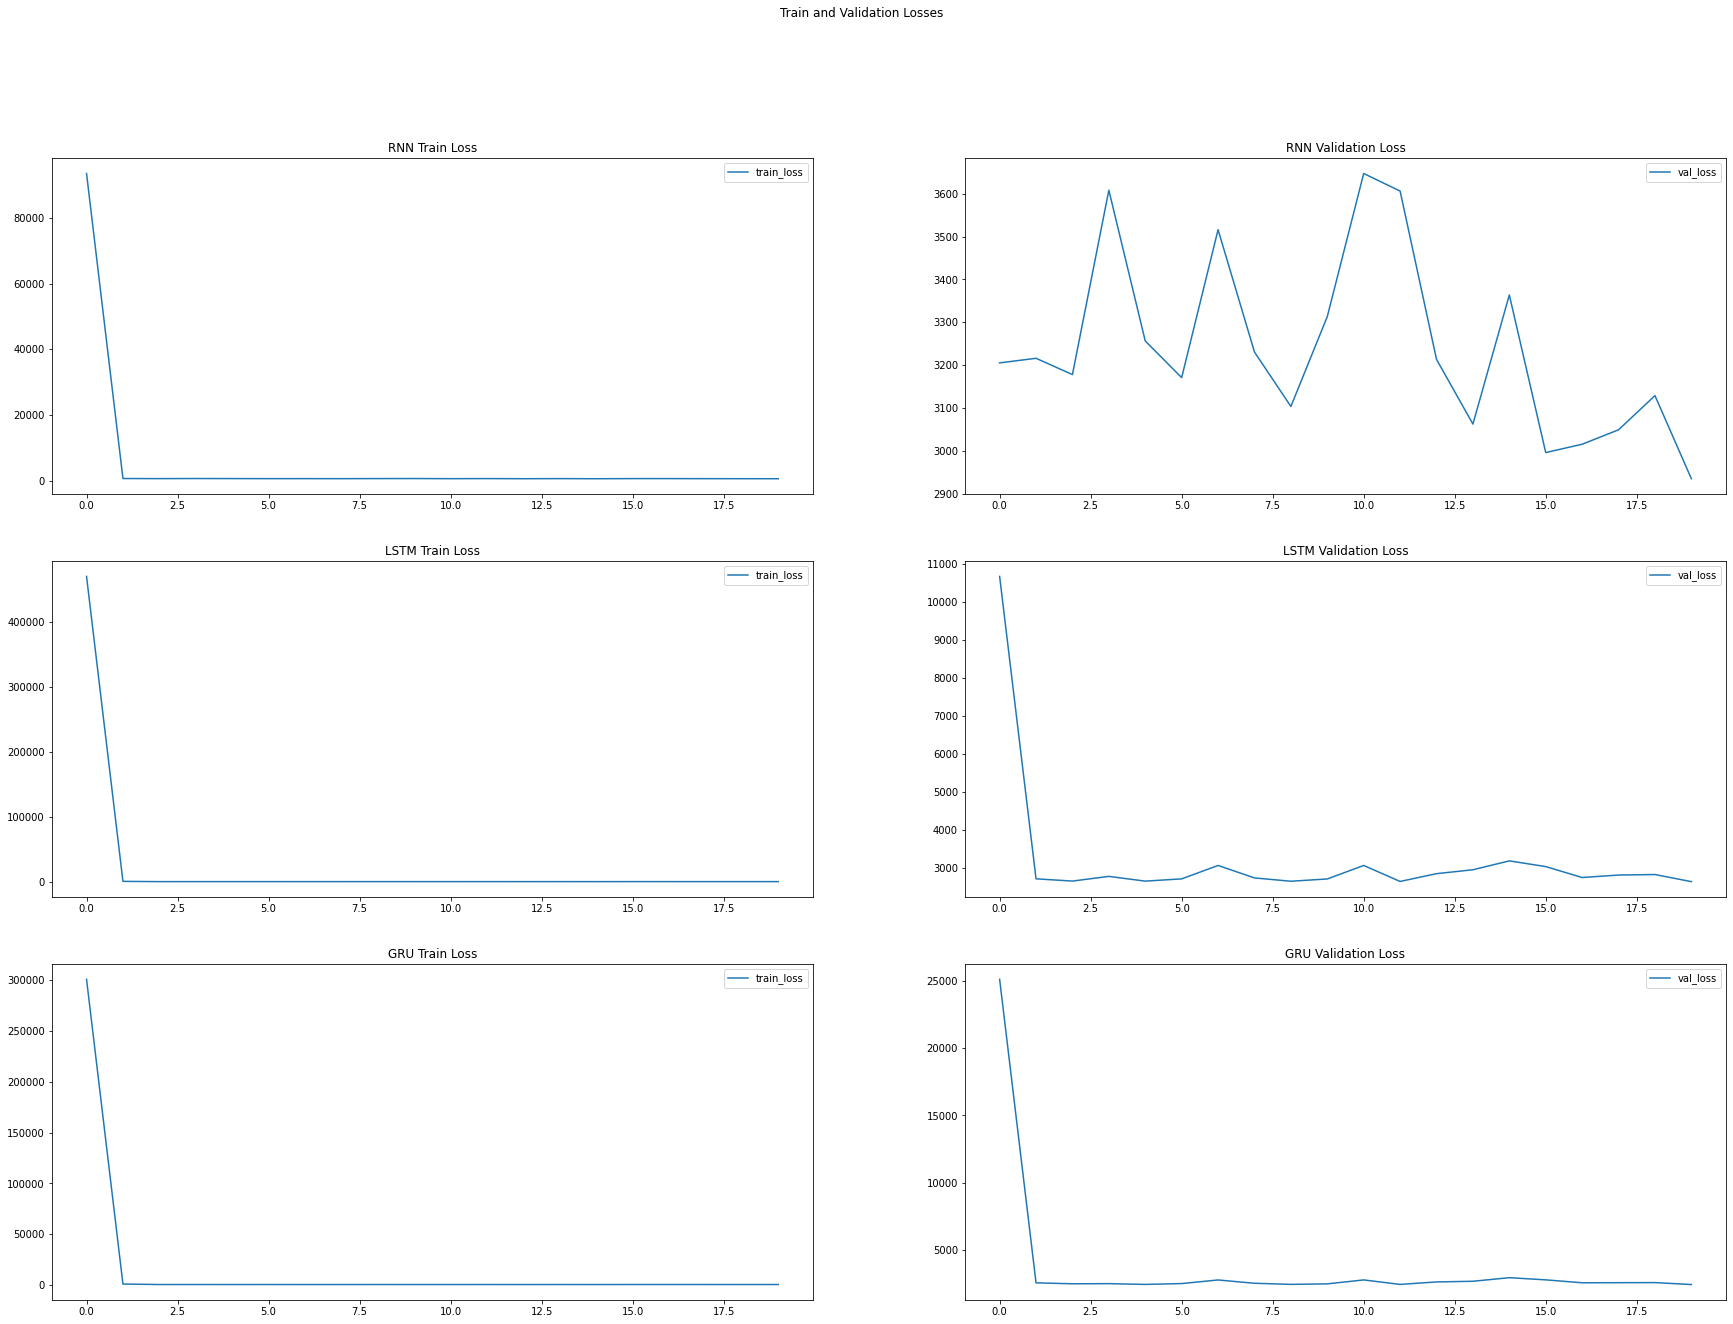

In [268]:
fig, axes = plt.subplots(3, 2, figsize=(30, 21))

axes[0][0].plot(rnn_history[['loss']].index, rnn_history[['loss']], label='train_loss')
axes[0][0].title.set_text('RNN Train Loss')
axes[0][0].legend()

axes[0][1].plot(rnn_history[['val_loss']].index, rnn_history[['val_loss']], label='val_loss')
axes[0][1].title.set_text('RNN Validation Loss')
axes[0][1].legend()

axes[1][0].plot(lstm_history[['loss']].index, lstm_history[['loss']], label='train_loss')
axes[1][0].title.set_text('LSTM Train Loss')
axes[1][0].legend()

axes[1][1].plot(lstm_history[['val_loss']].index, lstm_history[['val_loss']], label='val_loss')
axes[1][1].title.set_text('LSTM Validation Loss')
axes[1][1].legend()

axes[2][0].plot(gru_history[['loss']].index, gru_history[['loss']], label='train_loss')
axes[2][0].title.set_text('GRU Train Loss')
axes[2][0].legend()

axes[2][1].plot(gru_history[['val_loss']].index, gru_history[['val_loss']], label='val_loss')
axes[2][1].title.set_text('GRU Validation Loss')
axes[2][1].legend()
plt.suptitle('Train and Validation Losses')
plt.show()

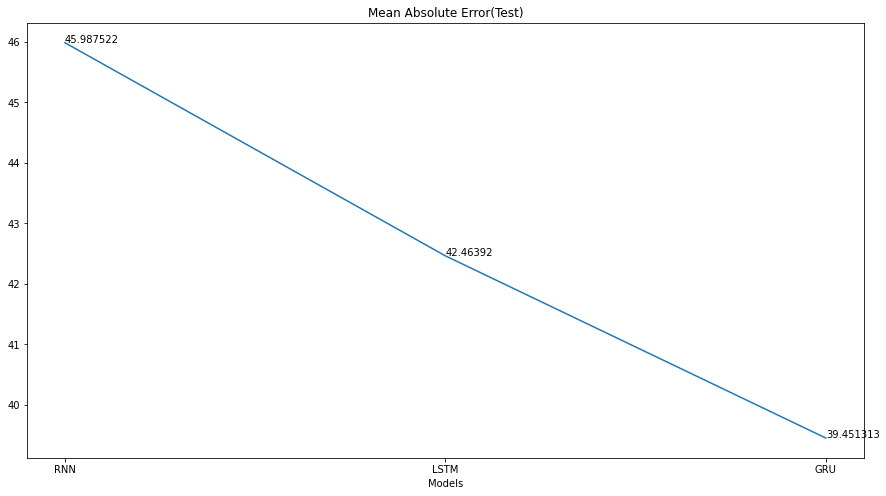

In [269]:
plt.figure(figsize=(15, 8))
plt.plot(['RNN', 'LSTM', 'GRU'], [rnn_test_mae, lstm_test_mae, gru_test_mae])
plt.title('Mean Absolute Error(Test)')
plt.xlabel('Models')
for index, value in enumerate([rnn_test_mae, lstm_test_mae, gru_test_mae]):
    plt.text(index, value, str(value.numpy()))
plt.show()

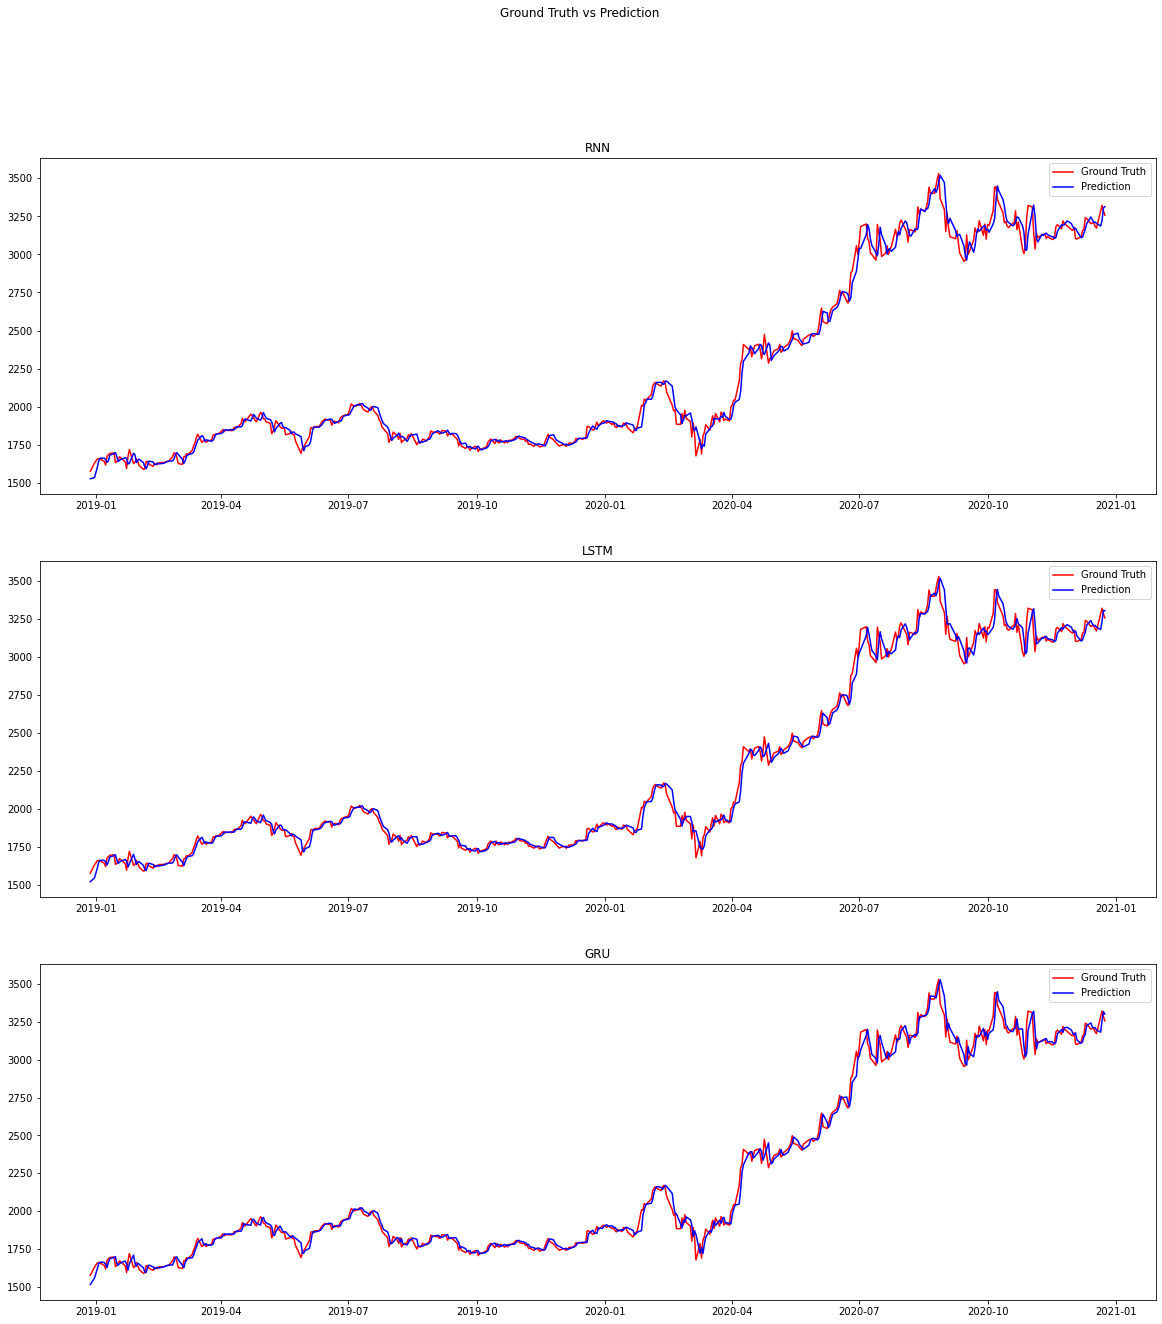

In [270]:
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
axes[0].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[0].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, rnn_val_preds, color = 'blue', label = 'Prediction')
axes[0].title.set_text('RNN')
axes[0].legend()

axes[1].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[1].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, lstm_val_preds, color = 'blue', label = 'Prediction')
axes[1].title.set_text('LSTM')
axes[1].legend()

axes[2].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[2].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, gru_val_preds, color = 'blue', label = 'Prediction')
axes[2].title.set_text('GRU')
axes[2].legend()
plt.suptitle('Ground Truth vs Prediction')
plt.show()

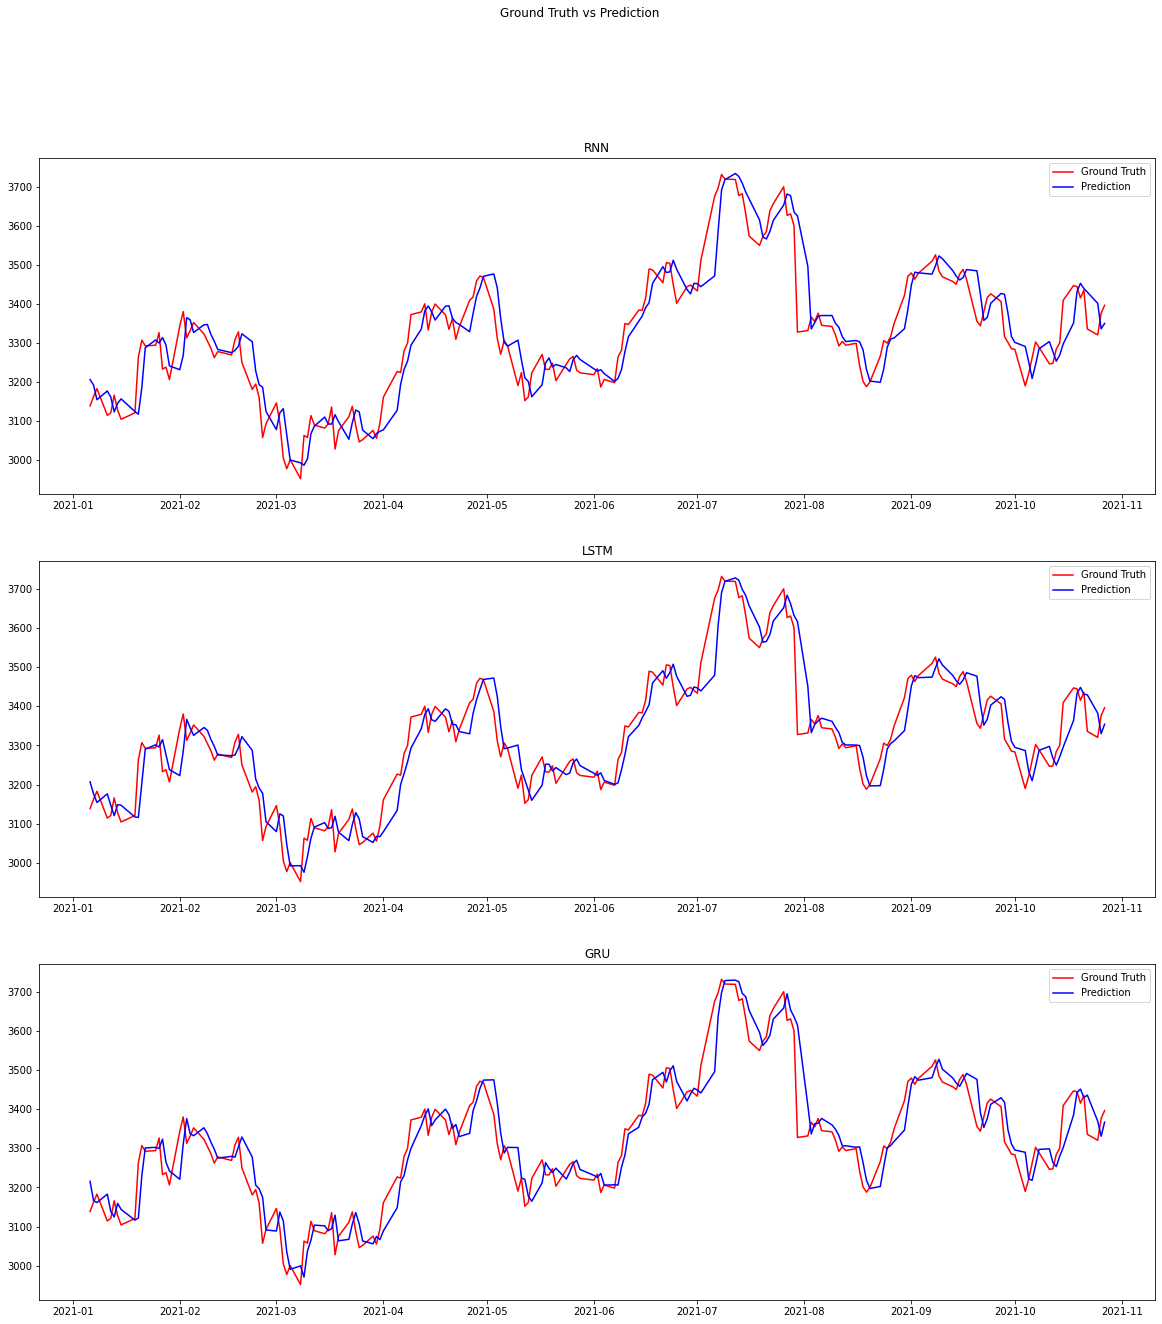

In [271]:
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
axes[0].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[0].plot(data[-Y_test.shape[0]:].index, rnn_test_preds, color = 'blue', label = 'Prediction')
axes[0].title.set_text('RNN')
axes[0].legend()

axes[1].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[1].plot(data[-Y_test.shape[0]:].index, lstm_test_preds, color = 'blue', label = 'Prediction')
axes[1].title.set_text('LSTM')
axes[1].legend()

axes[2].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[2].plot(data[-Y_test.shape[0]:].index, gru_test_preds, color = 'blue', label = 'Prediction')
axes[2].title.set_text('GRU')
axes[2].legend()
plt.suptitle('Ground Truth vs Prediction')
plt.show()

## Compare to feedforward network
Feedforward ANN can be used to solve this problem. We can use N days' value to predict N+1 day's value. However, we may need to construct a very deep(large number of hidden layers) and complicated(large number of hidden units in a hidden layer) model. The training time will increase and the performance may still be worse compare to RNN's. Moreover, with such a model we may experience gradient vanishing or exploding problems. Therefore, using feedforward network is not a good choice for such task.

## Word Embedding

Pretrained word embedding url: https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1  
Dissimilarity: Chebyshev Distance, calculated as max( (u_i - v_i) ) for all i.

In [272]:
strings = ["", ""]
strings[0] = input("Word 1: ")
strings[1] = input("Word 2: ")
print(strings)

Word 1:  this
Word 2:  that


['this', 'that']


In [273]:
embed = tfhub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1")

In [274]:
embeddings = embed(strings)
embeddings[0], embeddings[1]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.17849712, -0.04519277, -0.01800628,  0.03167261, -0.01759489,
        -0.05665898, -0.10084513,  0.04446944,  0.1136525 , -0.04387722,
        -0.05736724, -0.14388299, -0.05745615, -0.15731575, -0.10375199,
        -0.09802415,  0.00594332,  0.03937301,  0.0162055 ,  0.32337016,
        -0.01261148,  0.01625825,  0.14830582, -0.01721515,  0.08470592,
         0.01847644, -0.04344172, -0.09091296, -0.07765199,  0.07118276,
        -0.13054818, -0.02156414,  0.0047634 , -0.00123568, -0.0398718 ,
         0.06864961, -0.22894152, -0.03905505, -0.06981597, -0.03733263,
        -0.19146273,  0.01546862, -0.04202671,  0.16990612, -0.03966084,
        -0.07017914, -0.02287517, -0.19194342, -0.01852768,  0.02617534,
        -0.07232048, -0.01232366, -0.15919487,  0.11414526, -0.05757218,
         0.00601415,  0.00822029,  0.05547604, -0.02839203,  0.03645862,
         0.01695746, -0.06488681,  0.05952214, -0.03191975,  0.08337681,
  

In [275]:
cosine_similarity = np.dot(embeddings[0].numpy(), embeddings[1].numpy())/ (np.linalg.norm(embeddings[0].numpy()) * np.linalg.norm(embeddings[1].numpy()))
dissimilarity = chebyshev(embeddings[0].numpy(), embeddings[1].numpy())

In [276]:
print(f'Cosine Similarity: {cosine_similarity:.4f}')
print(f'Dissimilarity: {dissimilarity}')

Cosine Similarity: 0.4262
Dissimilarity: 0.2570379674434662
